In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdir = delphes_dir + "displacedPhoton/prompt_half_dark_events.root"
df = ROOT.RDataFrame("Delphes", fdir)


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
# Create the RDataFrame
df = ROOT.RDataFrame("Delphes", fdir)

# Filter out events that have no photons to prevent errors
# df = df.Filter("Photon_size > 0", "Events with at least one photon")

df = df.AsNumpy([
    "Event.Number",
    "Photon_size", "Photon.PT", "Photon.Eta", "Photon.Phi",
    "Jet_size", "Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass",
    "Tower_size", "Tower.ET", "Tower.Eta", "Tower.Phi",
    "MissingET.MET", "MissingET.Phi",
    "GenMissingET.MET", "GenMissingET.Eta", "GenMissingET.Phi"
    ]) # Add all relevant Branches

df = pd.DataFrame({
    "event": [arr[0] for arr in df["Event.Number"]],
    "photon_size": [arr for arr in df["Photon_size"]],
    "photon_pt": [arr for arr in df["Photon.PT"]],
    "photon_eta": [arr for arr in df["Photon.Eta"]],
    "photon_phi": [arr for arr in df["Photon.Phi"]],
    "jet_size": [arr for arr in df["Jet_size"]],
    "jet_pt": [arr for arr in df["Jet.PT"]],
    "jet_eta": [arr for arr in df["Jet.Eta"]],
    "jet_phi": [arr for arr in df["Jet.Phi"]],
    "jet_mass": [arr for arr in df["Jet.Mass"]],
    "tower_size": [arr for arr in df["Tower_size"]],
    "tower_et": [arr for arr in df["Tower.ET"]],
    "tower_eta": [arr for arr in df["Tower.Eta"]],
    "tower_phi": [arr for arr in df["Tower.Phi"]],
    "met": [arr[0] for arr in df["MissingET.MET"]],
    "met_phi": [arr[0] for arr in df["MissingET.Phi"]],
    "genmet": [arr[0] for arr in df["GenMissingET.MET"]],
    "genmet_eta": [arr[0] for arr in df["GenMissingET.Eta"]],
    "genmet_phi": [arr[0] for arr in df["GenMissingET.Phi"]],
})

# Sort the dataframe by the 'event' column and set it as the index
df = df.sort_values(by="event").set_index("event")

df.head()

,photon_size,photon_pt,photon_eta,photon_phi,jet_size,jet_pt,jet_eta,jet_phi,jet_mass,tower_size,tower_et,tower_eta,tower_phi,met,met_phi,genmet,genmet_eta,genmet_phi
event,,,,,,,,,,,,,,,,,,
0,1,[38.245750427246094],[1.5864211320877075],[-0.3361752927303314],1,[47.680904388427734],[2.985546350479126],[2.3954684734344482],[5.3620686531066895],144,"[0.08115574717521667, 0.05840836465358734, 0.0...","[-4.777219772338867, -4.619195461273193, -4.39...","[-2.7494759559631348, -0.3378962576389313, -2....",38.193195,-1.335756,39.143513,0.179296,-1.479393
1,1,[57.15996170043945],[0.3262680172920227],[-0.5488672852516174],1,[49.051002502441406],[2.9870760440826416],[2.3928637504577637],[6.501738548278809],145,"[0.07695319503545761, 0.0725039467215538, 0.06...","[-4.834770679473877, -4.565176963806152, -4.36...","[-2.625077486038208, -0.2685551941394806, -2.0...",21.571005,-2.194716,23.687180,1.921988,-1.932783
2,1,[46.879234313964844],[-0.24933868646621704],[-2.934141159057617],1,[48.19245147705078],[2.9677159786224365],[2.382195472717285],[5.250112056732178],137,"[0.08130796998739243, 0.07218136638402939, 0.0...","[-4.81563138961792, -4.605648994445801, -4.437...","[-2.7730820178985596, -0.29421037435531616, -1...",90.675583,-0.418172,95.386909,0.988994,-0.467594
3,2,"[57.2845344543457, 39.459129333496094]","[0.32174399495124817, 1.5839675664901733]","[-0.5415364503860474, -0.3481537997722626]",0,[],[],[],[],140,"[0.07334253937005997, 0.07057955861091614, 0.0...","[-4.986375331878662, -4.551105976104736, -4.50...","[-2.776808500289917, -0.21202325820922852, -2....",82.190346,2.799991,78.944168,2.318977,2.877817
4,2,"[45.162017822265625, 38.47255325317383]","[-0.24764174222946167, 1.5998356342315674]","[-2.9380741119384766, -0.3349236845970154]",0,[],[],[],[],139,"[0.08473055064678192, 0.057260509580373764, 0....","[-4.9927978515625, -4.588396072387695, -4.4315...","[-2.682823657989502, -0.17707009613513947, -1....",15.463243,-0.173613,17.324291,3.902051,-0.014991


In [3]:
def calc_met(row):
    """Calculate the missing transverse energy (MET) and its azimuthal angle (Phi) from the given row of data.
    MET is actually the missing momentum energy, not missing energy.

    Args:
        row (pd.Series): A row of the DataFrame containing jet and photon information.

    Returns:
        tuple[float, float]: A tuple containing the calculated MET and MET Phi.
    """
    # Generate Lorentz vectors for jets and photons
    jets = [ROOT.TLorentzVector() for _ in range(row["jet_size"])]
    for i in range(row["jet_size"]):
        # jets[i].SetPtEtaPhiM(row["jet_pt"][i], row["jet_eta"][i], row["jet_phi"][i], row["jet_mass"][i])
        jets[i].SetPtEtaPhiM(row["jet_pt"][i], 0, row["jet_phi"][i], 0) # Set eta and mass to 0 -- performs identically to above line.
        
    photons = [ROOT.TLorentzVector() for _ in range(row["photon_size"])]
    for i in range(row["photon_size"]):
        # photons[i].SetPtEtaPhiM(row["photon_pt"][i], row["photon_eta"][i], row["photon_phi"][i], 0)
        photons[i].SetPtEtaPhiM(row["photon_pt"][i], 0, row["photon_phi"][i], 0) # Set eta and mass to 0 -- performs identically to above line.

    towers = [ROOT.TLorentzVector() for _ in range(row["tower_size"])]
    for i in range(row["tower_size"]):
        # towers[i].SetPtEtaPhiM(row["tower_et"][i], row["tower_eta"][i], row["tower_phi"][i], 0)
        towers[i].SetPtEtaPhiM(row["tower_et"][i], 0, row["tower_phi"][i], 0) # Set eta and mass to 0 -- performs identically to above line.
        # towers[i].SetPtEtaPhiM(0, 0, row["tower_phi"][i], row["tower_et"][i]) # Set eta to 0 and mass to ET -- performs slightly better than above line.

    met = ROOT.TLorentzVector()
    # for j in jets:
    #     met -= j
    # for p in photons:
    #     met -= p
    for t in towers: # Checked delphes_card_ATLAS.tcl, MET is calculated only from towers.
        met -= t

    return met.Pt(), met.Phi()

0.96349672

In [4]:
df[["calc_met", "calc_met_phi"]] = df.apply(calc_met, axis=1, result_type="expand")
print(f"MET-calc_MET corr: \n{np.corrcoef(df['met'], df['calc_met'])}")
print(f"MET-calc-phi_MET_phi corr: \n{np.corrcoef(df['met_phi'], df['calc_met_phi'])}")
print(f"GenMET-calc_MET corr: \n{np.corrcoef(df['genmet'], df['calc_met'])}")
print(f"GenMET-MET corr: \n{np.corrcoef(df['genmet'], df['met'])}")
df.head()

MET-calc_MET corr: 
[[1. 1.]
 [1. 1.]]
MET-calc-phi_MET_phi corr: 
[[1. 1.]
 [1. 1.]]
GenMET-calc_MET corr: 
[[1.         0.96135386]
 [0.96135386 1.        ]]
GenMET-MET corr: 
[[1.         0.96135386]
 [0.96135386 1.        ]]


,photon_size,photon_pt,photon_eta,photon_phi,jet_size,jet_pt,jet_eta,jet_phi,jet_mass,tower_size,tower_et,tower_eta,tower_phi,met,met_phi,genmet,genmet_eta,genmet_phi,calc_met,calc_met_phi
event,,,,,,,,,,,,,,,,,,,,
0,1,[38.245750427246094],[1.5864211320877075],[-0.3361752927303314],1,[47.680904388427734],[2.985546350479126],[2.3954684734344482],[5.3620686531066895],144,"[0.08115574717521667, 0.05840836465358734, 0.0...","[-4.777219772338867, -4.619195461273193, -4.39...","[-2.7494759559631348, -0.3378962576389313, -2....",38.193195,-1.335756,39.143513,0.179296,-1.479393,38.193195,-1.335756
1,1,[57.15996170043945],[0.3262680172920227],[-0.5488672852516174],1,[49.051002502441406],[2.9870760440826416],[2.3928637504577637],[6.501738548278809],145,"[0.07695319503545761, 0.0725039467215538, 0.06...","[-4.834770679473877, -4.565176963806152, -4.36...","[-2.625077486038208, -0.2685551941394806, -2.0...",21.571005,-2.194716,23.687180,1.921988,-1.932783,21.571003,-2.194716
2,1,[46.879234313964844],[-0.24933868646621704],[-2.934141159057617],1,[48.19245147705078],[2.9677159786224365],[2.382195472717285],[5.250112056732178],137,"[0.08130796998739243, 0.07218136638402939, 0.0...","[-4.81563138961792, -4.605648994445801, -4.437...","[-2.7730820178985596, -0.29421037435531616, -1...",90.675583,-0.418172,95.386909,0.988994,-0.467594,90.675581,-0.418172
3,2,"[57.2845344543457, 39.459129333496094]","[0.32174399495124817, 1.5839675664901733]","[-0.5415364503860474, -0.3481537997722626]",0,[],[],[],[],140,"[0.07334253937005997, 0.07057955861091614, 0.0...","[-4.986375331878662, -4.551105976104736, -4.50...","[-2.776808500289917, -0.21202325820922852, -2....",82.190346,2.799991,78.944168,2.318977,2.877817,82.190347,2.799991
4,2,"[45.162017822265625, 38.47255325317383]","[-0.24764174222946167, 1.5998356342315674]","[-2.9380741119384766, -0.3349236845970154]",0,[],[],[],[],139,"[0.08473055064678192, 0.057260509580373764, 0....","[-4.9927978515625, -4.588396072387695, -4.4315...","[-2.682823657989502, -0.17707009613513947, -1....",15.463243,-0.173613,17.324291,3.902051,-0.014991,15.463242,-0.173613


(np.float64(2.3866066798537093e-07), np.float64(1.733880210041539e-06))

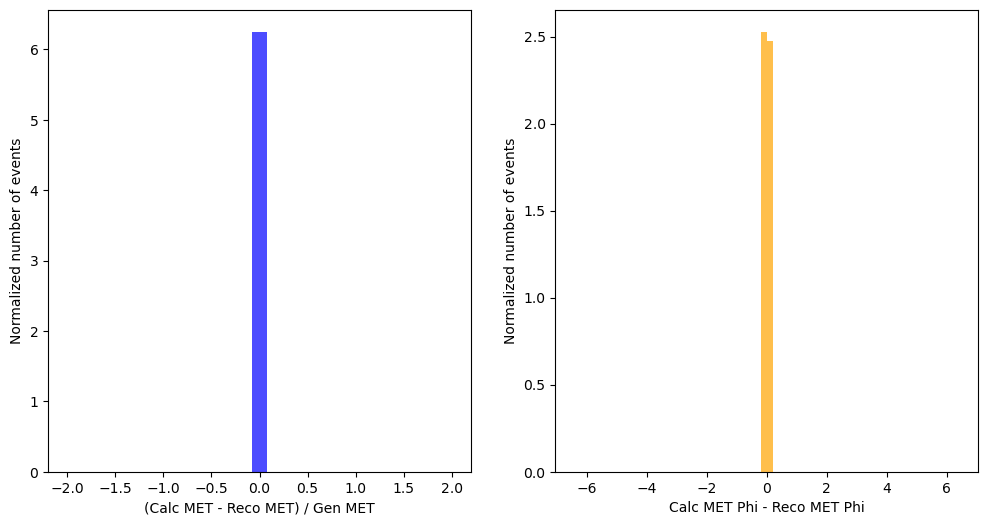

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist((df["calc_met"] - df["met"]) / df["genmet"], bins=50, range=(-2, 2), density=True, color='blue', alpha=0.7)
axes[0].set_xlabel("(Calc MET - Reco MET) / Gen MET")
axes[0].set_ylabel("Normalized number of events")

axes[1].hist((df["calc_met_phi"] - df["met_phi"]), bins=64, density=True, range=(-6.4, 6.4), color='orange', alpha=0.7)
axes[1].set_xlabel("Calc MET Phi - Reco MET Phi")
axes[1].set_ylabel("Normalized number of events")

np.std((df["calc_met"] - df["met"]) / df["genmet"]), np.std((df["calc_met_phi"] - df["met_phi"]))

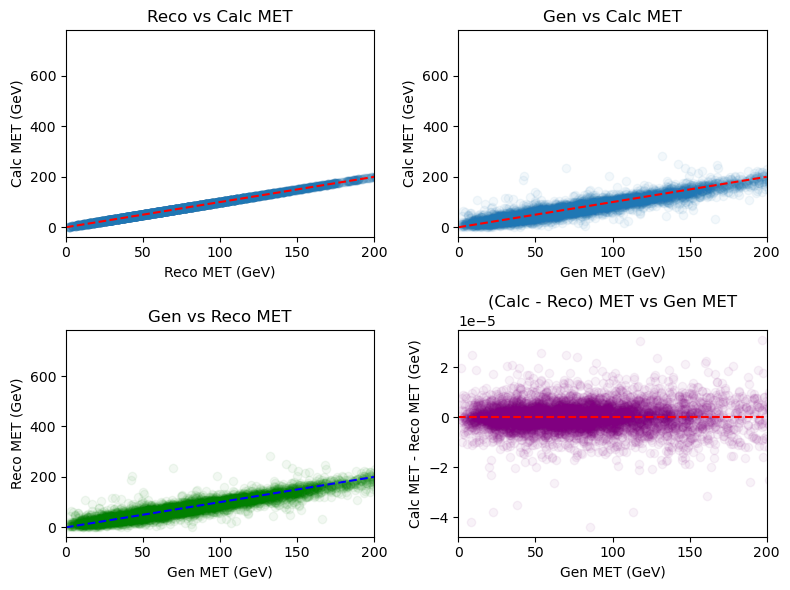

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
met_scatter_alpha = 0.05

# Plot 1: Reco MET vs Calc MET
axes[0, 0].scatter(df["met"], df["calc_met"], alpha=met_scatter_alpha)
axes[0, 0].set_xlabel("Reco MET (GeV)")
axes[0, 0].set_ylabel("Calc MET (GeV)")
axes[0, 0].set_title("Reco vs Calc MET")
axes[0, 0].plot([0, 200], [0, 200], color='red', linestyle='--')  # y=x line
axes[0, 0].set_xlim(0, 200)

# Plot 2: Calc MET vs Gen MET
axes[0, 1].scatter(df["genmet"], df["calc_met"], alpha=met_scatter_alpha)
axes[0, 1].set_xlabel("Gen MET (GeV)")
axes[0, 1].set_ylabel("Calc MET (GeV)")
axes[0, 1].set_title("Gen vs Calc MET")
axes[0, 1].plot([0, 200], [0, 200], color='red', linestyle='--')  # y=x line
axes[0, 1].set_xlim(0, 200)

# Plot 3: Reco MET vs Gen MET
axes[1, 0].scatter(df["genmet"], df["met"], alpha=met_scatter_alpha, color='green')
axes[1, 0].set_xlabel("Gen MET (GeV)")
axes[1, 0].set_ylabel("Reco MET (GeV)")
axes[1, 0].set_title("Gen vs Reco MET")
axes[1, 0].plot([0, 200], [0, 200], color='blue', linestyle='--')  # y=x line
axes[1, 0].set_xlim(0, 200)

# Plot 4: (Calc MET - Reco MET) vs Gen MET
axes[1, 1].scatter(df["genmet"], df["calc_met"] - df["met"], alpha=met_scatter_alpha, color='purple')
axes[1, 1].set_xlabel("Gen MET (GeV)")
axes[1, 1].set_ylabel("Calc MET - Reco MET (GeV)")
axes[1, 1].set_title("(Calc - Reco) MET vs Gen MET")
axes[1, 1].axhline(0, color='red', linestyle='--')  # y=0 line
axes[1, 1].set_xlim(0, 200)

plt.tight_layout()
plt.show()

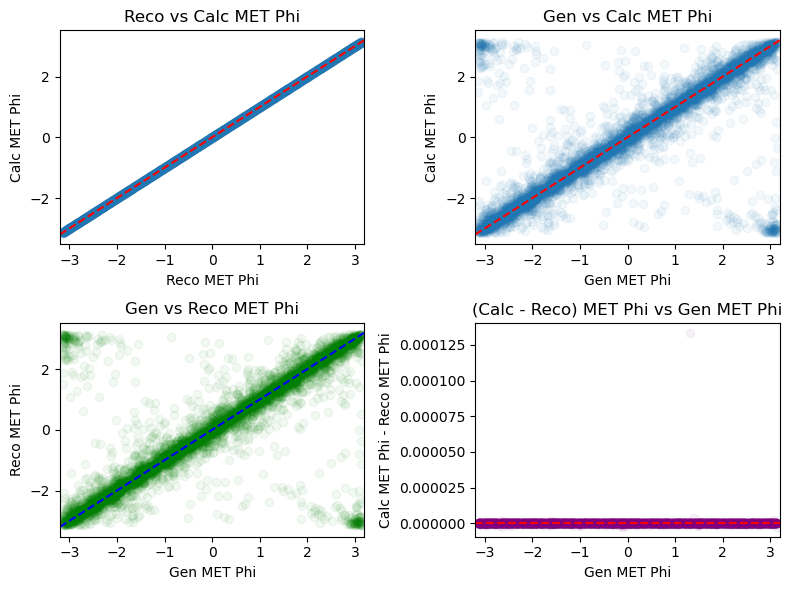

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
phi_scatter_alpha = 0.05

# Plot 1: Reco MET Phi vs Calc MET Phi
axes[0, 0].scatter(df["met_phi"], df["calc_met_phi"], alpha=phi_scatter_alpha)
axes[0, 0].set_xlabel("Reco MET Phi")
axes[0, 0].set_ylabel("Calc MET Phi")
axes[0, 0].set_title("Reco vs Calc MET Phi")
axes[0, 0].plot([-3.2, 3.2], [-3.2, 3.2], color='red', linestyle='--')  # y=x line
axes[0, 0].set_xlim(-3.2, 3.2)

# Plot 2: Calc MET Phi vs Gen MET Phi
axes[0, 1].scatter(df["genmet_phi"], df["calc_met_phi"], alpha=phi_scatter_alpha)
axes[0, 1].set_xlabel("Gen MET Phi")
axes[0, 1].set_ylabel("Calc MET Phi")
axes[0, 1].set_title("Gen vs Calc MET Phi")
axes[0, 1].plot([-3.2, 3.2], [-3.2, 3.2], color='red', linestyle='--')  # y=x line
axes[0, 1].set_xlim(-3.2, 3.2)

# Plot 3: Reco MET Phi vs Gen MET Phi
axes[1, 0].scatter(df["genmet_phi"], df["met_phi"], alpha=phi_scatter_alpha, color='green')
axes[1, 0].set_xlabel("Gen MET Phi")
axes[1, 0].set_ylabel("Reco MET Phi")
axes[1, 0].set_title("Gen vs Reco MET Phi")
axes[1, 0].plot([-3.2, 3.2], [-3.2, 3.2], color='blue', linestyle='--')  # y=x line
axes[1, 0].set_xlim(-3.2, 3.2)

# Plot 4: (Calc MET Phi - Reco MET Phi) vs Gen MET Phi
axes[1, 1].scatter(df["genmet_phi"], df["calc_met_phi"] - df["met_phi"], alpha=phi_scatter_alpha, color='purple')
axes[1, 1].set_xlabel("Gen MET Phi")
axes[1, 1].set_ylabel("Calc MET Phi - Reco MET Phi")
axes[1, 1].set_title("(Calc - Reco) MET Phi vs Gen MET Phi")
axes[1, 1].axhline(0, color='red', linestyle='--')  # y=0 line
axes[1, 1].set_xlim(-3.2, 3.2)

plt.tight_layout()
plt.show()

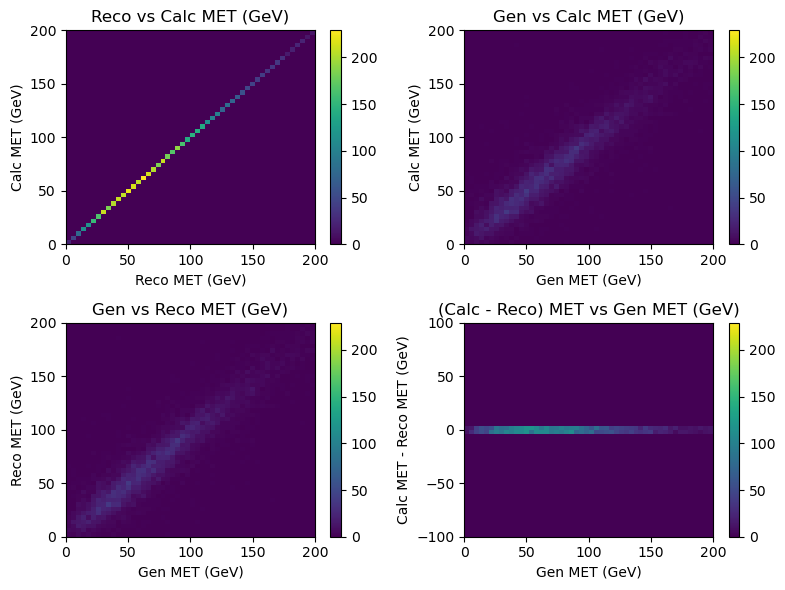

In [8]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
met_hist_bins = 50  # Number of bins for the 2D histograms
met_hist_range = [[0, 200], [0, 200]]
met_cmap = "viridis"

# Plot 1: Reco MET vs Calc MET
h1 = axes[0, 0].hist2d(df["met"], df["calc_met"], bins=met_hist_bins, range=met_hist_range, cmap=met_cmap)
axes[0, 0].set_xlabel("Reco MET (GeV)")
axes[0, 0].set_ylabel("Calc MET (GeV)")
axes[0, 0].set_title("Reco vs Calc MET (GeV)")
fig.colorbar(h1[3], ax=axes[0, 0])

# Plot 2: Calc MET vs Gen MET
h2 = axes[0, 1].hist2d(df["genmet"], df["calc_met"], bins=met_hist_bins, range=met_hist_range, cmap=met_cmap)
axes[0, 1].set_xlabel("Gen MET (GeV)")
axes[0, 1].set_ylabel("Calc MET (GeV)")
axes[0, 1].set_title("Gen vs Calc MET (GeV)")
fig.colorbar(h2[3], ax=axes[0, 1])

# Plot 3: Reco MET vs Gen MET
h3 = axes[1, 0].hist2d(df["genmet"], df["met"], bins=met_hist_bins, range=met_hist_range, cmap=met_cmap)
axes[1, 0].set_xlabel("Gen MET (GeV)")
axes[1, 0].set_ylabel("Reco MET (GeV)")
axes[1, 0].set_title("Gen vs Reco MET (GeV)")
fig.colorbar(h3[3], ax=axes[1, 0])

# Plot 4: (Calc MET - Reco MET) vs Gen MET
h4 = axes[1, 1].hist2d(df["genmet"], df["calc_met"] - df["met"], bins=met_hist_bins, range=[[0, 200], [-100, 100]], cmap=met_cmap)
axes[1, 1].set_xlabel("Gen MET (GeV)")
axes[1, 1].set_ylabel("Calc MET - Reco MET (GeV)")
axes[1, 1].set_title("(Calc - Reco) MET vs Gen MET (GeV)")
fig.colorbar(h4[3], ax=axes[1, 1])

# Normalize the colorbar across all plots
norm = Normalize(vmin=0, vmax=max(h1[0].max(), h2[0].max(), h3[0].max(), h4[0].max()))
h1[3].set_norm(norm)
h2[3].set_norm(norm)
h3[3].set_norm(norm)
h4[3].set_norm(norm)

plt.tight_layout()
plt.savefig("calc_met.png")
plt.show()


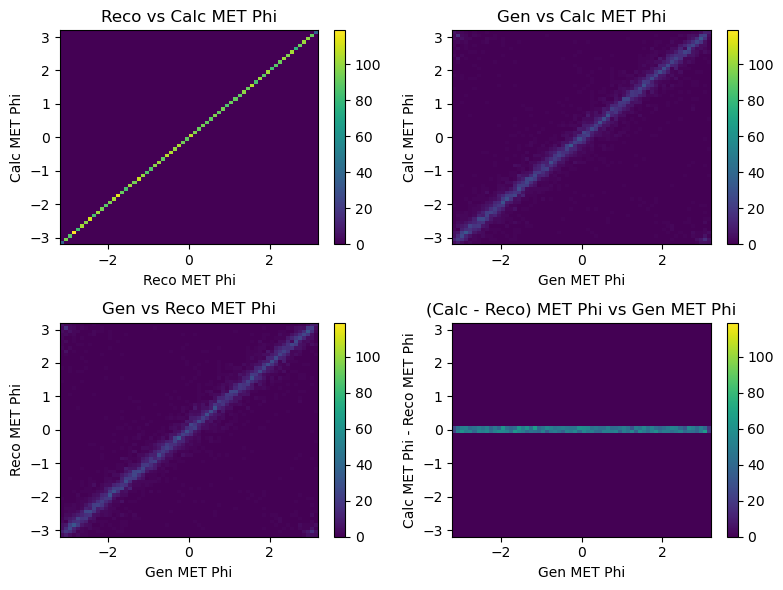

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
phi_hist_bins = 64 # Number of bins for the 2D histograms
phi_hist_range = [[-3.2, 3.2], [-3.2, 3.2]]  # Adjusted range for phi values
phi_cmap = "viridis"

# Plot 1: Reco MET Phi vs Calc MET Phi
h1 = axes[0, 0].hist2d(df["met_phi"], df["calc_met_phi"], bins=phi_hist_bins, range=phi_hist_range, cmap=phi_cmap)
axes[0, 0].set_xlabel("Reco MET Phi")
axes[0, 0].set_ylabel("Calc MET Phi")
axes[0, 0].set_title("Reco vs Calc MET Phi")
fig.colorbar(h1[3], ax=axes[0, 0])

# Plot 2: Calc MET Phi vs Gen MET Phi
h2 = axes[0, 1].hist2d(df["genmet_phi"], df["calc_met_phi"], bins=phi_hist_bins, range=phi_hist_range, cmap=phi_cmap)
axes[0, 1].set_xlabel("Gen MET Phi")
axes[0, 1].set_ylabel("Calc MET Phi")
axes[0, 1].set_title("Gen vs Calc MET Phi")
fig.colorbar(h2[3], ax=axes[0, 1])

# Plot 3: Reco MET Phi vs Gen MET Phi
h3 = axes[1, 0].hist2d(df["genmet_phi"], df["met_phi"], bins=phi_hist_bins, range=phi_hist_range, cmap=phi_cmap)
axes[1, 0].set_xlabel("Gen MET Phi")
axes[1, 0].set_ylabel("Reco MET Phi")
axes[1, 0].set_title("Gen vs Reco MET Phi")
fig.colorbar(h3[3], ax=axes[1, 0])

# Plot 4: (Calc MET Phi - Reco MET Phi) vs Gen MET Phi
h4 = axes[1, 1].hist2d(df["genmet_phi"], df["calc_met_phi"] - df["met_phi"], bins=phi_hist_bins, range=phi_hist_range, cmap=phi_cmap)
axes[1, 1].set_xlabel("Gen MET Phi")
axes[1, 1].set_ylabel("Calc MET Phi - Reco MET Phi")
axes[1, 1].set_title("(Calc - Reco) MET Phi vs Gen MET Phi")
fig.colorbar(h4[3], ax=axes[1, 1])

# Normalize the colorbar across all plots
norm = Normalize(vmin=0, vmax=max(h1[0].max(), h2[0].max(), h3[0].max(), h4[0].max()))
h1[3].set_norm(norm)
h2[3].set_norm(norm)
h3[3].set_norm(norm)
h4[3].set_norm(norm)

plt.tight_layout()
plt.savefig("calc_met_phi.png")
plt.show()
